# GEOL 593: Seismology and Earth Structure

## Lab assignment 2: Introduction to Obspy and signal processing

Obspy is a powerful (and popular) Python-based toolkit for seismology. It allows us to download data from data centers such as IRIS (https://www.iris.edu/hq/), read and write multiple seismic data formats, perform signal processing, and visualize our data. Additionally it is open source, which has facilitated the rapid development of many community codes in seismology that utilize Obspy. This lab exercise is meant to provide an introduction to the Obspy software, and give an overview of some of the main ways we can use it to download and manipulate seismic data. The full Obspy documentation can be found here: https://github.com/obspy/obspy/wiki. The code was first introduced to the community in Beyreuther et al., (2010), although it has grown considerably since then. (https://pubs.geoscienceworld.org/ssa/srl/article/81/3/530/143693/obspy-a-python-toolbox-for-seismology)

In [1]:
import obspy
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
%matplotlib inline

### The UTCDateTime object

Seismology deals with data as a function of time, so naturally we want an easy way to reference times and dates. This is where Obspy's UTCDateTime class comes in handy. The 'UTC' stands for Coordinated Universal Time (https://en.wikipedia.org/wiki/Coordinated_Universal_Time). By default, Obspy's UTCDateTime uses a reference time of Thursday, Jan 1, 1970, so if you intitialize an instance of this class for a time = 0, it will refer to this time.

In [2]:
from obspy import UTCDateTime
utc = UTCDateTime(0)
print(utc)

1970-01-01T00:00:00.000000Z


You can access the attributes of the UTCDateTime as shown below

In [3]:
print(utc.year)
print(utc.month)
print(utc.day)
print(utc.hour)
print(utc.minute)
print(utc.second)

1970
1
1
0
0
0


There are several different ways of intializing a UTCDateTime object for a specific date. 

In [4]:
print(UTCDateTime("2021-07-11T04:10:36.2"))        # time as a string
print(UTCDateTime(2011, 7, 11, 4, 10, 26, 2))      # ordered arguments (year, month, day, etc.)
print(UTCDateTime(1625976636.2))                   #time in s, from Jan 1 1970

2021-07-11T04:10:36.200000Z
2011-07-11T04:10:26.000002Z
2021-07-11T04:10:36.200000Z


You can also take the difference between two UTCDateTime objects, or add time to one (in s)

In [5]:
u0 = UTCDateTime(0)
u1 = UTCDateTime('2022-01-01T01:01')
print(u1 - u0) #difference in s
print(u1 + 60) #print u1 plus 60 seconds

1640998860.0
2022-01-01T01:02:00.000000Z


#### <font color='red'> Question 1. Make a list of 10 UTCDateTime objects, starting at the beggining of this year, and increasing progressively by 20 minutes. </font>

In [6]:
# Answer Q1 here. 
utc_list = ['UTCDateTime("2023-01-01T12:00:00.0")', 'UTCDateTime("2023-01-01T12:20:00.0")', 'UTCDateTime("2023-01-01T12:40:00.0")', 'UTCDateTime("2023-01-01T01:00:00.0")', 'UTCDateTime("2023-01-01T01:20:00.0")', 'UTCDateTime("2023-01-01T01:40:00.0")', 'UTCDateTime("2023-01-01T02:00:00.0")', 'UTCDateTime("2023-01-01T02:20:00.0")', 'UTCDateTime("2023-01-01T02:40:00.0")', 'UTCDateTime("2023-01-01T03:00:00.0")']
for item in utc_list:
    print(item)

UTCDateTime("2023-01-01T12:00:00.0")
UTCDateTime("2023-01-01T12:20:00.0")
UTCDateTime("2023-01-01T12:40:00.0")
UTCDateTime("2023-01-01T01:00:00.0")
UTCDateTime("2023-01-01T01:20:00.0")
UTCDateTime("2023-01-01T01:40:00.0")
UTCDateTime("2023-01-01T02:00:00.0")
UTCDateTime("2023-01-01T02:20:00.0")
UTCDateTime("2023-01-01T02:40:00.0")
UTCDateTime("2023-01-01T03:00:00.0")


### Downloading data from IRIS

In this exercise, we will be analyzing data from a Mw 7.5 earthquake that occurred in N. Peru on 11-28-2021 (IRIS event page: https://ds.iris.edu/ds/nodes/dmc/tools/event/11501860). We will download data from the station "US.HDIL", which is a broadband seismometer located in Hopedale, Illinois (near Bloomington). We will download the data using the obspy client. 

Note, if you are interested in exploring other recent earthquakes, and which stations data is available from, you can interactively browse through the IRIS catalog of global earthquakes using Wilber3 (https://ds.iris.edu/wilber3/find_event)

In [7]:
from obspy import UTCDateTime
origin = UTCDateTime('2021-11-28T10:52:13.239000Z')
sta = 'HDIL'
net = 'US'
print(origin)

2021-11-28T10:52:13.239000Z


In [8]:
from obspy.clients.fdsn import Client
client = Client("IRIS")
origin = UTCDateTime('2021-11-28T10:52:13.239000Z') #event origin time (notice its a UTCDateTime object)
starttime = origin
duration_s = 60.*60. #1 hour of data
endtime = origin + duration_s
net = 'US'
sta = 'HDIL'
channel = 'BH*' #BH code = Broadband, High-gain. The 'wildcard'(*) means we want any channel that starts with BH
location = '00' #location code

#we will download the seismic data with "client.get_waveforms"
st = client.get_waveforms(net, sta, location, channel, starttime, endtime,attach_response=True) #downloads data and returns "stream" object
print(type(st)) #it is often useful to call the type() function to double check you know the type of object you have

<class 'obspy.core.stream.Stream'>


### The obspy "stream" 

One of the main data structures we use in Obspy is called the "stream" object. It is essentially a list, or collection of seismograms. Each seismogram, together with its metadata, is stored in a "trace" object. When we called "client.get_waveforms()", the data from IRIS was returned as a stream. 

To summarize what is contained in the stream, we can call the print function (as below). Notice how there are three traces, with channels BH1, BH2, and BHZ. BHZ is the vertical component seismogram and BH1 and BH2 are the two horizontal directions. Often, you will see BHN and BHE used (for North and East) instead of BH1 and BH2. The reason some networks prefer to use '1' and '2' instead of 'N' and 'E' is because occassionally the horizontal components won't be perfectly aligned with the cardinal directions (sometimes due to installation error). When '1' and '2' are used for horizonal components, the station metadata will contain the true direction that each of these components are oriented, given in degrees from north. In this case, the BH1 channel is almost perfectly aligned North, and the BH2 channel is almost perfectly aligned East. Below we will explore how to access data and metadata contained in a stream.

Note, the channel codes (e.g., BHZ) describe not only the component of ground motion, but give information about the instrument sensitivity (and sampling rate). For the "B" in BHZ stands for "Broad-band" and the "H" stands for "High-gain". A complete list of channel codes can be found here: https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/

In [9]:
print(st)   #calling the print function summarizes what is contained in the stream

3 Trace(s) in Stream:
US.HDIL.00.BH1 | 2021-11-28T10:52:13.250000Z - 2021-11-28T11:52:13.225000Z | 40.0 Hz, 144000 samples
US.HDIL.00.BH2 | 2021-11-28T10:52:13.250000Z - 2021-11-28T11:52:13.225000Z | 40.0 Hz, 144000 samples
US.HDIL.00.BHZ | 2021-11-28T10:52:13.250000Z - 2021-11-28T11:52:13.225000Z | 40.0 Hz, 144000 samples


In [10]:
print(len(st)) #the len() function will return the number of items in a stream, just like how it works on lists

3


We can access individual "traces" using an index (same as lists or arrays), or by using the .select() function.

In [11]:
stc = st.copy() #this step isn't necessary, but making a copy means that if we change things, the original will be preserved.
tr0 = stc[0] #access the first trace in the stream and assign it to "tr0"
trz = st.select(channel='BHZ')[0] #note, even though there is only 1 BHZ trace, we still need to grab the first entry,
                                  #(i.e., [0]). This is because the 'select' function returns a *stream* and we want a *trace*
print(tr0)
print(trz)
print(type(tr0))
print(type(trz))

US.HDIL.00.BH1 | 2021-11-28T10:52:13.250000Z - 2021-11-28T11:52:13.225000Z | 40.0 Hz, 144000 samples
US.HDIL.00.BHZ | 2021-11-28T10:52:13.250000Z - 2021-11-28T11:52:13.225000Z | 40.0 Hz, 144000 samples
<class 'obspy.core.trace.Trace'>
<class 'obspy.core.trace.Trace'>


Let's see what is contained in the trace. There are two main things that are stored. i) the actual seismic waveform data, which is stored in trace.data  (this is stored as a numpy array) and ii) metadata, stored in 'trace.stats'. 

In [12]:
print(trz.data)
print(trz.stats)

[ 300  332  310 ... 1961 1943 1920]
               network: US
               station: HDIL
              location: 00
               channel: BHZ
             starttime: 2021-11-28T10:52:13.250000Z
               endtime: 2021-11-28T11:52:13.225000Z
         sampling_rate: 40.0
                 delta: 0.025
                  npts: 144000
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 367, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 576512})
            processing: ['ObsPy 1.4.0: trim(endtime=UTCDateTime(2021, 11, 28, 11, 52, 13, 250000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2021, 11, 28, 10, 52, 13, 250000))']
              response: Channel Response
	From m/s (Velocity in meters per second) to counts (Digital Count in Digital counts)
	Overall Sensitivity: 6.1362

The **stats** object is a special data type, but it works a lot like a dictionary. You can access any of the fields in stats in two ways.

In [13]:
print(trz.stats.sampling_rate)
print(trz.stats['sampling_rate'])

40.0
40.0


#### <font color='red'> Question 2. The sampling rate of the data is 40 Hz. What is the highest frequency signal that can be accurately represented with this sampling rate?</font>


In [14]:
#Answer Q2 Here: 20 Hz


Let's take a look at the data! The simplest way to plot a stream is to use the built-in plot() method. Calling plot() without any arguments will create a default plot, although the function can take many arguments to customize aspects of the plot. Remember, you can use "help" to see how functions work, including arguments that take. (i.e., help(st.plot()).

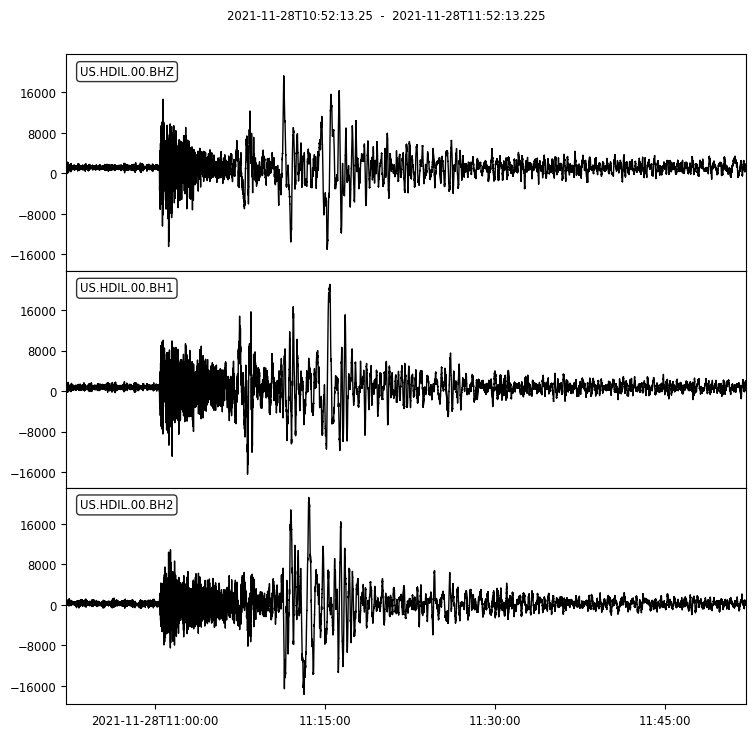

In [15]:
fig = st.plot()
#note, you usually don't need to return 'st.plot()' to a variable as I did here, but for some reason if you don't it will draw the plot twice.

### Instrument response removal

When you download raw seismic data from a data center (e.g., IRIS), the data will be in "counts", which is the raw number read off the physical intstrument (basically a voltage). Additionally, the instrument itself modulates the true signal because it does not respond to every frequency the same. Some frequencies may be amplified/diminished and/or phase shifted. To make sense of the data, we need to translate the counts to meaningful units of ground motion (e.g., displacement, velocity, acceleration). The process of translating from instrument counts to 'true' ground motion is known as instrument response removal, or instrument correction. It requires knowledge of the instrument response function, which essentially describes how an impulsive input signal (e.g. a 'spike') would be recorded by the instrument. The instrument response is then 'deconvolved' from the raw data to translate to ground motion. 

Deconvolution in the frequency domain is commonly performed via a spectral division, e.g.,

$X(\omega) = \frac{U(\omega)}{I(\omega)}$, where $X(\omega)$ is the ground motion we would like to recover, $U(\omega)$ is the raw seismogram, and $I(\omega)$ is the instrument response. In practice, this deconvolution may be unstable because the denominator may have values close to 0 at certain frequencies. Therefore, we typically perform deconvolution in the frequency domain using a 'water level' to stabilize the spectral division. 

$X(\omega) = \frac{I*(\omega)}{\mathrm{max}(|I(\omega)|^2, \alpha)}{U(\omega)}$

where $I*(\omega)$ is the complex conjugate of $I(\omega)$,  $|I(\omega)|^2$ is the spectrum, and $\alpha$ is the water level. 

The cell below contains code to perform the instrument response removal. Note, the "remove_response" function only works if the instrument response information is attached to the stream. In this case, it is, because we set "attach_response=True" when we were downloading the waveforms.

#### <font color='red'> Question 3. Run the cell below for different water-levels between about 0 - 100 (i.e., change the alpha parameter). What happens as you increase alpha? Based on your experimentation, what would you consider a reasonable choice of alpha? Why? </font>

2.5539789941060132e-05


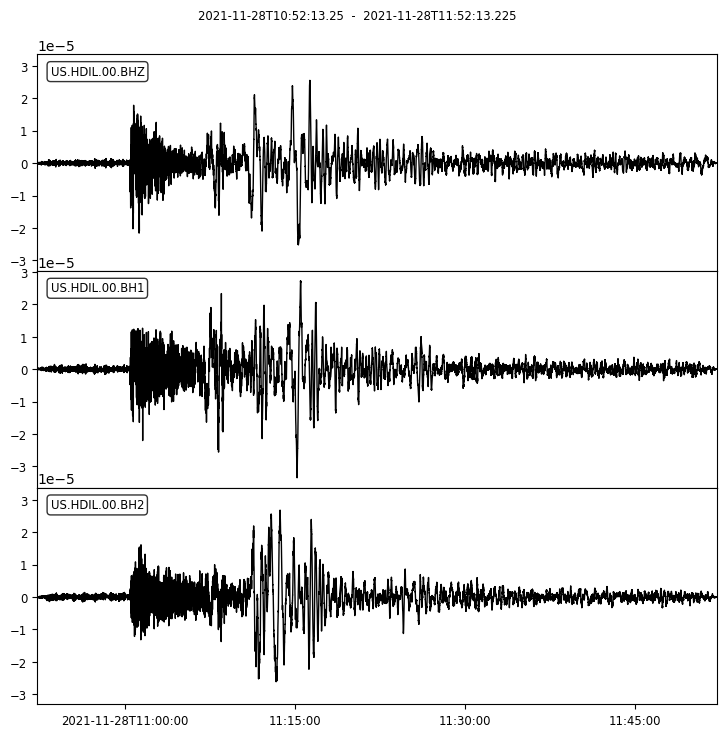

In [16]:
alpha = 0.0
stc = st.copy() #this copies the original stream to a new object (wont modify the original)
stc.remove_response(output='VEL',water_level=alpha) #deconvolve to velocity, in m/s
print(np.max(stc.select(channel='*HZ')[0].data))
fig = stc.plot()

In [17]:
#Answer Q3 here. (you can use a Markdown cell instead of code cell if you would like).

#The horizontal directions start swaying and eventually the vertical direction waves start swaying as well. I presume this would be caused by the water level displacing the waves by a certain amount.

### Plotting spectra

The data of a trace object is stored in a numpy array, and can be accessed by calling Trace.data. Below we are going to plot amplitude spectrum of the vertical component using a fast fourier transform. 

Remember, the amplitude spectrum of $A(\omega)$ is $\sqrt{\mathrm{Re}[A(\omega)^2] + \mathrm{Im}[A(\omega)^2]}$

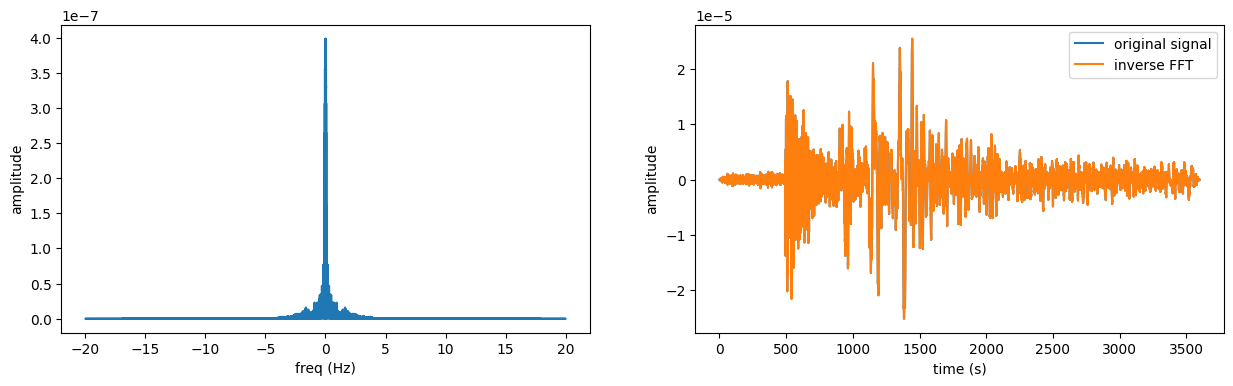

In [18]:
trz = stc.select(channel='BHZ')[0]
sampling_rate = trz.stats.sampling_rate
npts = trz.stats.npts
time = trz.times() #creates a time vector, starting at 0.

data = trz.data
data_w = np.fft.fft(data) #perform fast fourier transform
freq = np.fft.fftfreq(len(data),d=1./sampling_rate) #get array of frequencies (d is the time sampling increment)

data_t = np.fft.ifft(data_w) #inverse fft (return to time domain)

#make plots
fig,axes = plt.subplots(figsize=[15,4],ncols=2)

#plot amplitude spectrum (left axis)
axes[0].plot(freq,np.abs(data_w)/npts) #np.abs finds the magnitude of the complex vector. we need to divide it by the total number of points
axes[0].set_xlabel('freq (Hz)')
axes[0].set_ylabel('amplitude')

#plot inverse FFT signal (right axis)
axes[1].plot(time,data,label='original signal')
axes[1].plot(time,data_t.real,label='inverse FFT')
axes[1].set_xlabel('time (s)')
axes[1].set_ylabel('amplitude')
plt.legend()

plt.show()

#### <font color='red'> Question 4. 
    
Above, we took a signal, transformed it to the frequency domain (forward fft) and transformed it back to the time domain (inverse fft). Since we didn't modify the signal in the frequency domain at all, the 'recovered' signal should be the same as the original signal (with the exception of some numerical noise). Below, "mute" (i.e., zero) all of the negative frequency components of the signal in the frequency domain prior to performing the inverse fft. What happens to the time domain signal when you do this? (Show what happens by plotting the the time domain signal compared to the original). 
    
Detailed documentation on how to index numpy arrays can be found here: https://numpy.org/doc/stable/user/basics.indexing.html

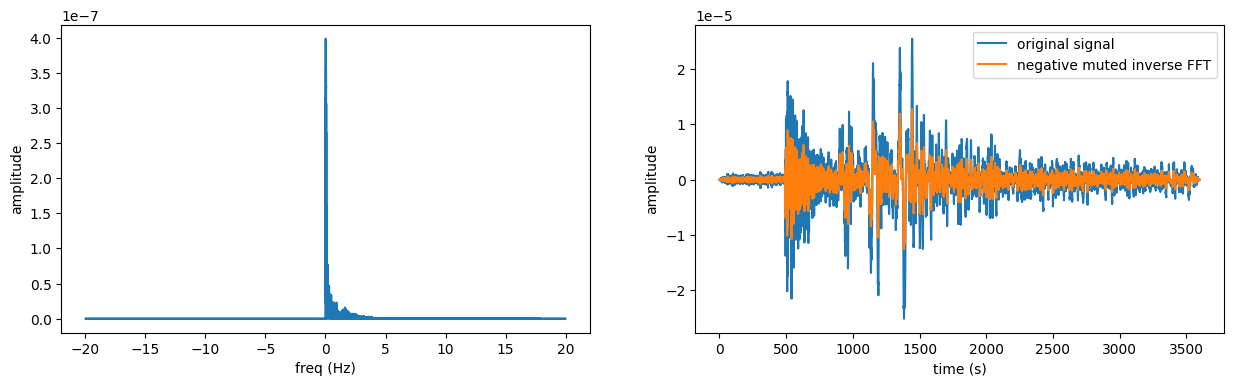

In [19]:
#Answer Q4 here
trz = stc.select(channel='BHZ')[0]
sampling_rate = trz.stats.sampling_rate
npts = trz.stats.npts
time = trz.times() #creates a time vector, starting at 0.

data = trz.data
data_w = np.fft.fft(data) #perform fast fourier transform
freq = np.fft.fftfreq(len(data),d=1./sampling_rate) #get array of frequencies (d is the time sampling increment)
data_w[freq < 0] = 0

data_t = np.fft.ifft(data_w) #inverse fft (return to time domain)

#make plots
fig,axes = plt.subplots(figsize=[15,4],ncols=2)

#plot amplitude spectrum (left axis)
axes[0].plot(freq,np.abs(data_w)/npts) #np.abs finds the magnitude of the complex vector. we need to divide it by the total number of points
axes[0].set_xlabel('freq (Hz)')
axes[0].set_ylabel('amplitude')

#plot inverse FFT signal (right axis)
axes[1].plot(time,data,label='original signal')
axes[1].plot(time,data_t.real,label='negative muted inverse FFT')
axes[1].set_xlabel('time (s)')
axes[1].set_ylabel('amplitude')
plt.legend()

plt.show()

Since the amplitude spectrum (and power spectrum) is often symmetric about omega = 0 (i.e., the magnitude of positive and negative frequency components are the same), we often plot spectra showing only positive frequencies. Note, in this case, the amplitude of the positive components should be multiplied by 2 so that the amplitudes match those in the time domain. Additionally, rather than plotting the amplitude spectrum (i.e., the absolute value of the complex fft components) or power spectrum (amplitude spectrum squared), we will plot "spectral density", in which the amplitude or power is given per Hz. Below, we will show an example of how to plot the power spectrum of a seismogram using scipy's "signal.welch" function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html).

Text(0, 0.5, 'power')

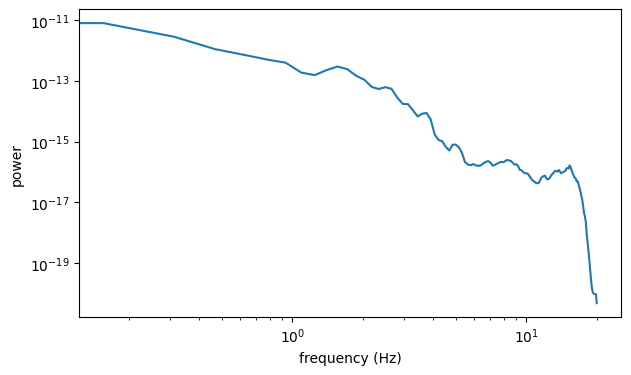

In [20]:
from scipy.signal import welch
f,Pxx = welch(x = data, fs = sampling_rate)

fig,ax = plt.subplots(figsize=[7,4])
plt.loglog(f,Pxx)
plt.xlabel('frequency (Hz)')
plt.ylabel('power')

#### <font color='red'> Question 5. 


a) What are the units of power in the plot above? (Hint, we deconvolved to velocity in m/s).

b) You will often see power spectra plotted in the log unit dB (decibels), where dB = $20 \log_{10}\left( \frac{A_{in}}{A_{ref}} \right)$, where $A_{in}$ is the $\textbf{amplitude}$ of the signal, and $V_{ref}$ is a reference value (here assume to be 1). Below, plot the power of the signal in dB. Note, that since dB is already a logarithmic unit, you shouldn't use a "loglog" plot as above. Instead, either use plt.plot or plt.semilogx (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.semilogx.html). 

Text(0, 0.5, 'power (dB)')

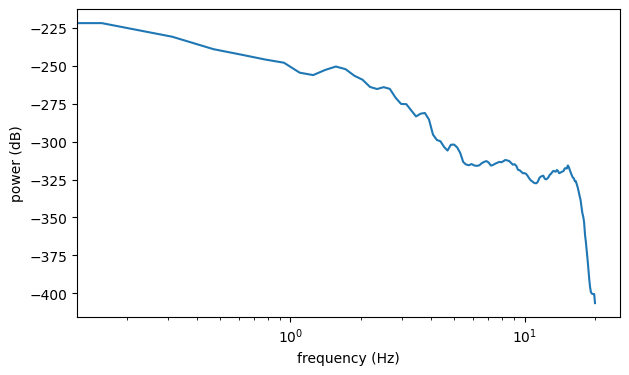

In [21]:
#Answer Q5 here
#For question a the units are m/s^2
#For question b:

from scipy.signal import welch
f,Pxx = welch(x = data, fs = sampling_rate)
Pxx_dB = 20 * np.log10(Pxx)

fig,ax = plt.subplots(figsize=[7,4])
plt.semilogx(f,Pxx_dB)
plt.xlabel('frequency (Hz)')
plt.ylabel('power (dB)')

### Filtering

The Stream object has many useful methods for processing seismic data, including the Stream.filter() function, which allows you to filter the data in a stream in several different ways (https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.filter.html). An example of a 'bandpass' filter is shown below. By default, a Butterworth filter is used (https://en.wikipedia.org/wiki/Butterworth_filter). 

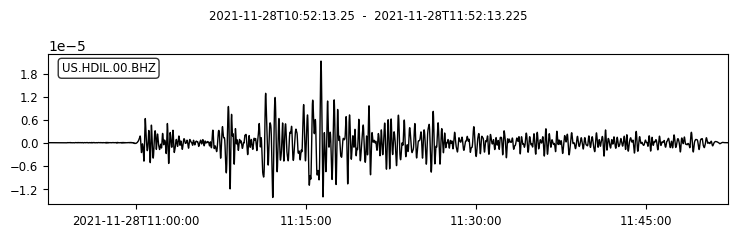

In [22]:
trz_c = trz.copy()
freqmin = 1./50.0 #low frequency cutoff (period = 50 s)
freqmax = 1./10.0  #high frequency cutoff (period = 10 s)

trz_c.taper(0.05)# before filtering, it is best to 'taper' the ends of the signal, to avoid artifacts (https://docs.obspy.org/master/packages/autogen/obspy.core.trace.Trace.taper.html)
trz_c.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=2,zerophase=True) #corners = filter 'order', zerophase = 'acausal' fitler
fig = trz_c.plot()

#### <font color='red'> Question 6. 
    
Plot the vertical component seismogram filtered in 3 different bands; **i) between 0.01 Hz - 0.02 Hz, ii) between 0.02 Hz - 0.1 Hz, and iii) between 0.1 - 1 Hz**. To do this, you will need to use Matplotlib instead of the built-in Obspy plot functions. You can either plot all the signals on the same axis, or create 3 separate axes [e.g., with axes = plt.subplots(ncols=3)]. If you plot all the signals on the same axis, be sure to set the 'alpha' parameter (i.e., the line transparency) to be lower than 1 (e.g., 0.5) so you can see all of the lines. Also, label each line [e.g., plt.plot(x,y,label='my line')], and include a legend [e.g., plt.legend()].
    
Hints
    
- To create a 'time axis' you can use Trace.times(). It will start at t=0, which in our case is the event origin time.
    
- You should make copies of the original signal prior to filtering (Trace.copy()), rather than repeatedly trying to filter the same signal. The filtering is done 'in-place', meaning that once you filter the signal, you lose the original data.

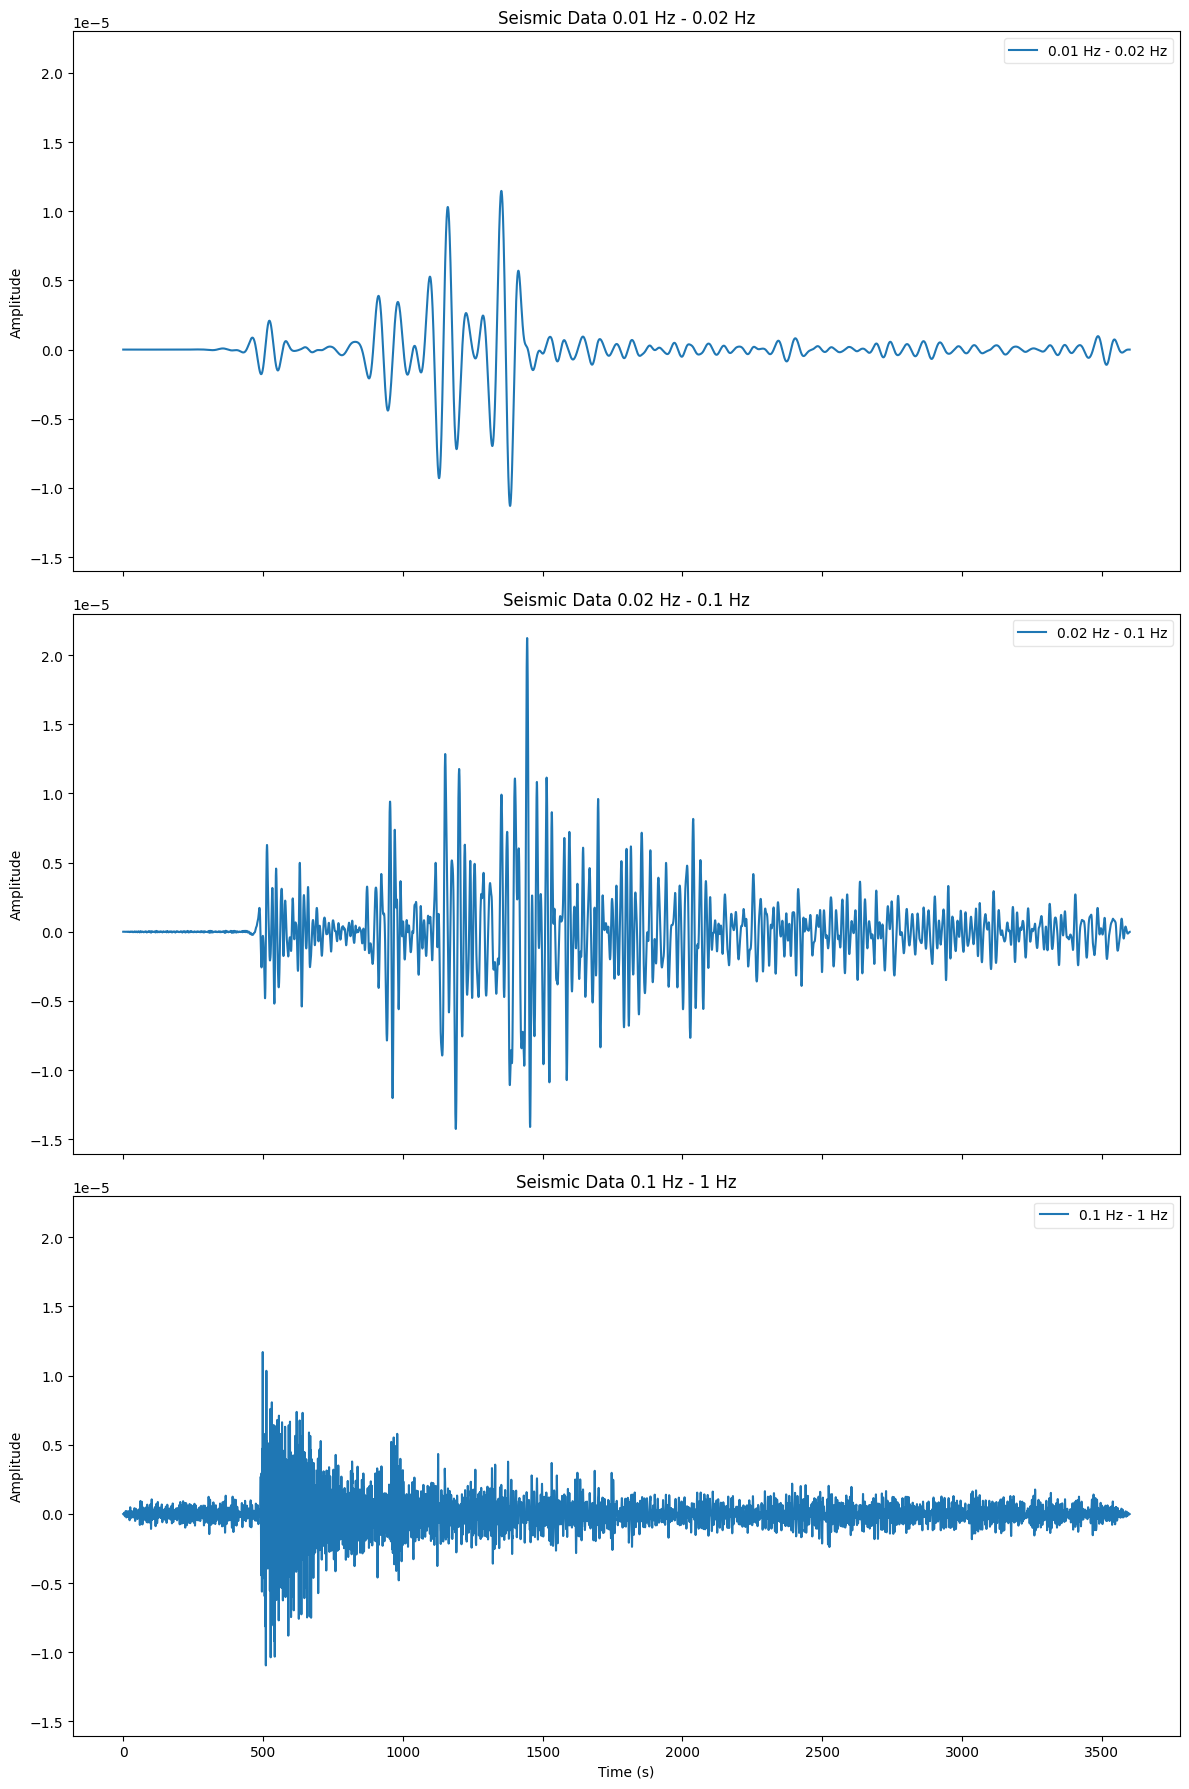

In [23]:
#Answer Q6 here

import matplotlib.pyplot as plt
from obspy import Trace

frequency_bands = [(0.01, 0.02), (0.02, 0.1), (0.1, 1)]

trz_copy = trz.copy()

time_axis = trz_copy.times()

fig, axes = plt.subplots(nrows=3, figsize=(12, 18), sharex=True, sharey=True)

for idx, freq_band in enumerate(frequency_bands):
    freq_min, freq_max = freq_band
    
    trz_filtered = trz_copy.copy()
    
    trz_filtered.filter('bandpass', freqmin=freq_min, freqmax=freq_max, corners=2, zerophase=True)
    
    axes[idx].plot(time_axis, trz_filtered.data, label=f'{freq_min} Hz - {freq_max} Hz')
    
    axes[idx].set_title(f'Seismic Data {freq_min} Hz - {freq_max} Hz')
    axes[idx].set_ylabel('Amplitude')
    
    axes[idx].legend(loc='best', framealpha=0.5)

axes[-1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

#### <font color='red'> Question 7. The first arriving energy (near 500 s) is the P-wave. The S-wave arrives near 900 s. The high amplitude signals after this are mostly surface waves (Rayleigh). What do you notice about the frequency content of the P-wave relative to the Rayleigh waves?

In [24]:
#Answer Q7 here: The frequency of the P-wave relative to the Rayleigh waves is that the P-wave strength is more visible at higher frequency, but Rayleigh waves are more prominent at lower frequencies.

### Component rotation

Although seismic instruments often record ground motion in the directions up/down, east/west, and north/south, sometimes we would like to use a different coordinate system. A natural reference frame to use when dealing with earthquake signals is called the "ZRT" coordinate system, where Z = 'vertical', R = 'radial', T = 'transverse'. In this coordinate system, the horizontal components are rotated such that the 'radial' component aligns with the direction of the earthquake source, and the 'transverse' component is orthogonal to it. The vertical component doesn't change. 

See here for a useful visual: https://service.iris.edu/irisws/rotation/docs/1/help/

Below we will perform a coordinate rotation on the stream using Stream.rotate() The rotation requires knowing the direction (in degrees) that the earthquake energy is arriving from. We call this the 'back-azimuth'.

In [ ]:
from obspy.geodetics import gps2dist_azimuth

stla = 40.5559 #latitude of seismometer
stlo = -89.294 #longitude of seismometer
evla = -4.4898 #latitude of earthquake
evlo = -76.8461 #longitude of earthquake

#the function gps2dist_azimuth allows us to get the distance and azimuths between two geographic points
dist_m,az,baz = gps2dist_azimuth(lat1=evla,lon1=evlo,lat2=stla,lon2=stlo) #returns distance (in m), azimuth, back azimuth
dist_km = dist_m / 1000. #distance in m
dist_deg = dist_km / 111.1 #there are approximately 111 km per degree

print('back azimuth', baz)
print('distance (km)', dist_km)
print('distance (degrees)', dist_deg)

#we will download additional station metadata from US.HDIL using "client.get_stations"
inv = client.get_stations(network='US',station='HDIL',starttime=starttime,endtime=endtime,level='response')
stc.rotate(method='->ZNE', inventory=inv) #first rotate from BH1, BH2 to BHN, BHE
stc.rotate(method='NE->RT', back_azimuth = baz) #rotate to BHR, BHT
print(st)

trz = stc.select(channel='BHZ')[0]
trr = stc.select(channel='BHR')[0]
trt = stc.select(channel='BHT')[0]
fig,axes = plt.subplots(figsize=[14,10],nrows=3)
axes[2].plot(trz.times(),trz.data)
axes[1].plot(trr.times(),trr.data)
axes[0].plot(trt.times(),trt.data)
axes[2].set_title('BHZ')
axes[1].set_title('BHR')
axes[0].set_title('BHT')
axes[2].set_xlabel('time (s)')
plt.tight_layout()

back azimuth 162.68000044016452
distance (km) 5147.206788296346
distance (degrees) 46.32949404407152
3 Trace(s) in Stream:
US.HDIL.00.BH1 | 2021-11-28T10:52:13.250000Z - 2021-11-28T11:52:13.225000Z | 40.0 Hz, 144000 samples
US.HDIL.00.BH2 | 2021-11-28T10:52:13.250000Z - 2021-11-28T11:52:13.225000Z | 40.0 Hz, 144000 samples
US.HDIL.00.BHZ | 2021-11-28T10:52:13.250000Z - 2021-11-28T11:52:13.225000Z | 40.0 Hz, 144000 samples


### Envelopes and the Hilbert Transform

The envelope of a signal draws a boundary in which the signal is contained. It is useful because it can tell you where you have energy present in your signals. To calculate the envelope, we need to first take what is called its *Hilbert Transform*. The Hilbert Transform is an operation in which a signal is convolved with the function $g(t) = \frac{1}{\pi t}$, which has the effect of shifting the phase of all frequency components by $\frac{\pi}{2}$. Think of this as essentially swapping the coefficients of the sine and cosine functions that make up the signal. We can use scipy's signal.hilbert function to do this. Below, we will take the Hilbert transform of the transverse component seismogram, and plot its envelope. The envelope is the absolute value of the *analytic signal*, which is what is returned by scipy.signal.hilbert. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

In [ ]:
from scipy.signal import hilbert

data_t = trt.copy().data
data_t_an = hilbert(data_t)

fig = plt.figure(figsize=[14,4])
plt.plot(trt.times(),data_t)
plt.plot(trt.times(),np.abs(data_t_an),label='envelope')
plt.xlabel('time (s)')
plt.legend()
plt.show()

#### <font color='red'> Question 8. The long period, high amplitude energy on the transverse component is the Love wave train. Based on the timing of the peak amplitude in the envelope function, what is the approximate velocity (in km/s) of the long period Love waves?
    
Hint: the epicentral distance was calculated above, where we calculated the event back azimuth.

In [ ]:
#Answer Q8 here.
Time = 1300
Distance = 5147.206788296346
velocity = Distance / Time
print(velocity, 'km/s')

### <font color='green'> Bonus question

In the frequency domain, taking a derivative is equivalent to multiplying by $i\omega$. Show that this is true by plotting a Gaussian function as well as its first and second derivatives, where the differentiation is performed in the frequency domain. The first box below defines the Gaussian function in the time domain.

In [ ]:
from scipy.signal import gaussian
npts = 100
L = 10
dt = L/npts #sample spacing
t = np.linspace(0,L,npts)
f = gaussian(M=npts,std=5)
fig = plt.figure(figsize=[7,3])
plt.plot(t,f)

In [ ]:
#Answer bonus question here.

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian

npts = 100
L = 10
dt = L / npts
t = np.linspace(0, L, npts)
f = gaussian(M=npts, std=5)

F = np.fft.fft(f)

omega = 2 * np.pi * np.fft.fftfreq(npts, dt)

F_derivative = 1j * omega * F

f_derivative = np.fft.ifft(F_derivative).real

F_second_derivative = -omega**2 * F

f_second_derivative = np.fft.ifft(F_second_derivative).real

plt.figure(figsize=[12, 6])

plt.subplot(3, 1, 2)
plt.plot(omega, np.abs(F_derivative))
plt.title('First Derivative')

plt.subplot(3, 1, 3)
plt.plot(omega, np.abs(F_second_derivative))
plt.title('Second Derivative')

plt.tight_layout()
plt.show()

In [ ]:
print("Hello world")

In [2]:
import obspy
st = obspy.read(r"C:\Users\wille\OneDrive\Documents\fdsnws-dataselect_2023-11-07t20_30_27z.mseed")

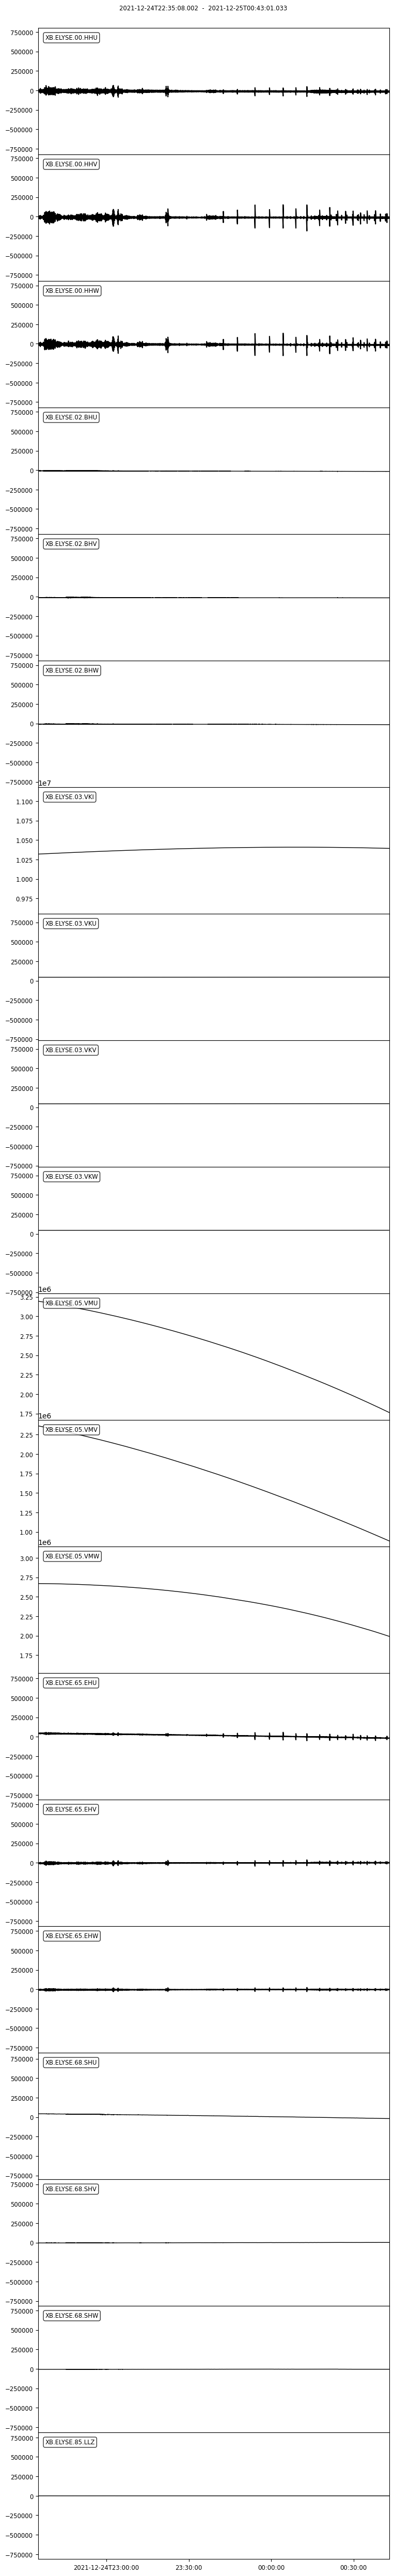

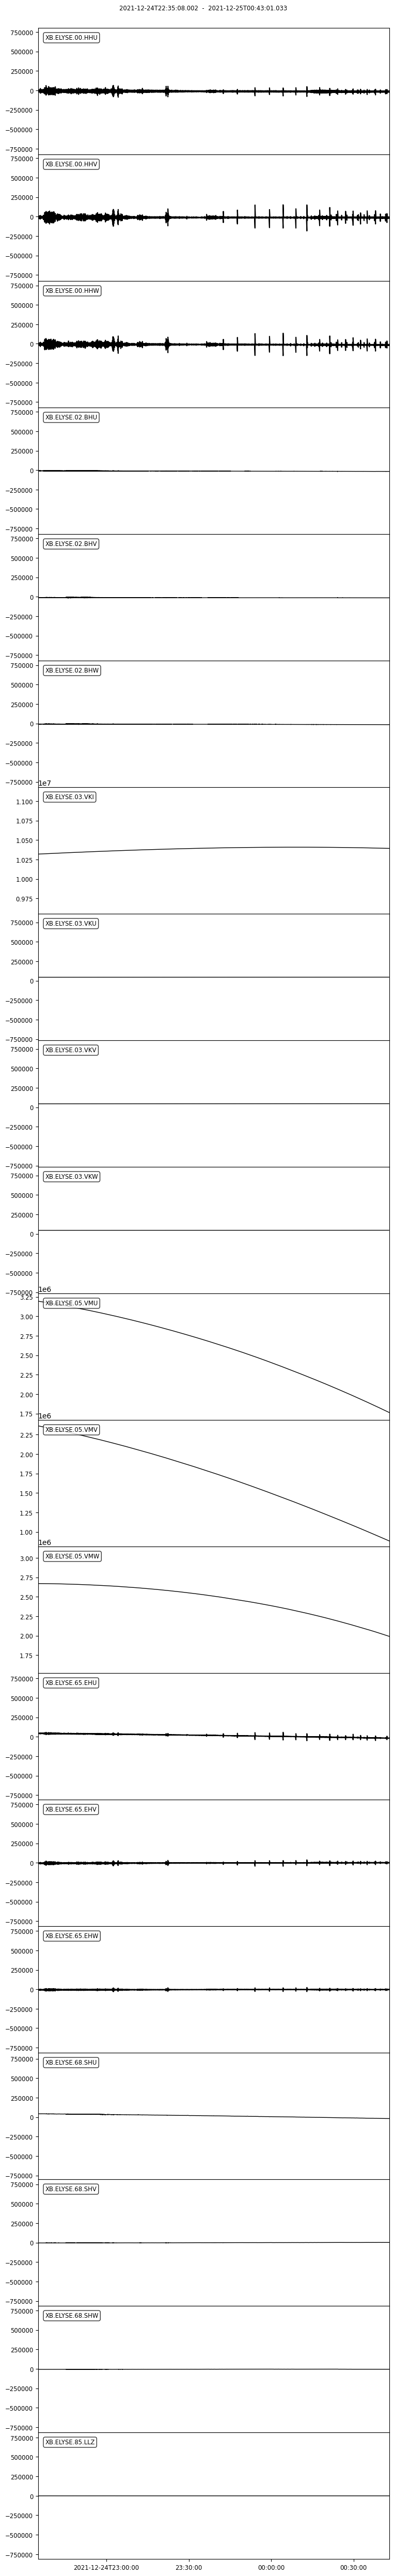

In [3]:
st.plot()

In [4]:
obspy.__version__

'1.4.0'

In [ ]:
pip install obspy==1.4.0 --user

In [ ]:
conda install obspy==1.4.0 -c conda-forge